In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.fft import fft, ifft

import torch
from torch import nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

from arch import arch_model
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from ipywidgets import IntProgress
from IPython.display import display
import warnings

## Data Fetching and Pre-processing

In [2]:
df_ohlc = pd.read_csv('data/SOL_1d_data.csv', parse_dates=True, index_col=0)
df_ohlc.head()

,open,high,low,close,volume,vwap,transactions
timestamp,,,,,,,
2023-12-30,106.16,107.59,100.69,101.92,1.035264e+06,103.4447,85673
2023-12-31,101.91,105.28,99.29,101.84,1.402462e+06,102.5917,96682
2024-01-01,101.70,110.44,101.47,110.11,1.626238e+06,105.8227,108681
2024-01-02,109.90,117.03,106.00,106.74,2.735153e+06,111.1942,200857
2024-01-03,106.77,110.04,71.00,98.59,4.241949e+06,99.1378,276745


In [3]:
df_FED = pd.read_csv('data/FED_data.csv', parse_dates=True, index_col=0)
df_FED.head()

,FEDFUNDS,CPIAUCSL
2023-12-30,5.33,309.794
2023-12-31,5.33,309.794
2024-01-01,5.33,309.794
2024-01-02,5.33,311.022
2024-01-03,5.33,311.022


In [4]:
df = pd.concat([df_ohlc, df_FED], axis=1)
df.head()

,open,high,low,close,volume,vwap,transactions,FEDFUNDS,CPIAUCSL
2023-12-30,106.16,107.59,100.69,101.92,1.035264e+06,103.4447,85673,5.33,309.794
2023-12-31,101.91,105.28,99.29,101.84,1.402462e+06,102.5917,96682,5.33,309.794
2024-01-01,101.70,110.44,101.47,110.11,1.626238e+06,105.8227,108681,5.33,309.794
2024-01-02,109.90,117.03,106.00,106.74,2.735153e+06,111.1942,200857,5.33,311.022
2024-01-03,106.77,110.04,71.00,98.59,4.241949e+06,99.1378,276745,5.33,311.022


In [5]:
df['log_ret'] = np.log(df['close']/(df['close'].shift(1)))
df = df.dropna()

In [6]:
df.head()

,open,high,low,close,volume,vwap,transactions,FEDFUNDS,CPIAUCSL,log_ret
2023-12-31,101.91,105.28,99.29,101.84,1.402462e+06,102.5917,96682,5.33,309.794,-0.000785
2024-01-01,101.70,110.44,101.47,110.11,1.626238e+06,105.8227,108681,5.33,309.794,0.078077
2024-01-02,109.90,117.03,106.00,106.74,2.735153e+06,111.1942,200857,5.33,311.022,-0.031084
2024-01-03,106.77,110.04,71.00,98.59,4.241949e+06,99.1378,276745,5.33,311.022,-0.079426
2024-01-04,98.57,108.26,96.67,105.01,2.364127e+06,102.6787,156567,5.33,311.022,0.063086


In [7]:
split_date = df.index[int(len(df) * 0.7)]

df_train = df.loc[:split_date]
df_test  = df.loc[split_date:]

## Neural Network

In [100]:
class NN(nn.Module):
    def __init__(self, n_features, M, hidden_size=32, n_layers=2):
        super(NN, self).__init__()

        self.model = nn.GRU(
            input_size=n_features, 
            hidden_size=hidden_size, 
            num_layers=n_layers, 
            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)
        self.scaler = StandardScaler()
        self.M = M

    def forward(self, x):
        gru_out, _ = self.model(x)
        last_output = gru_out[:, -1, :]
        output = self.fc(last_output)
        return output
        
    def _train(self, df, idx, target, num_epochs=20):
        if idx == self.M:
            self.scaler.fit(df.iloc[:idx].values)

        if(os.path.exists(f'snapshots/model{idx-1}.pth')):
            model.load_state_dict(torch.load(f'snapshots/model{idx-1}.pth'))

        train_data = df.iloc[idx-self.M:idx].values
        train_scaled = self.scaler.transform(train_data)
        train_tensor = torch.FloatTensor(train_scaled).unsqueeze(0)
        target_tensor = torch.FloatTensor([[target]])

        criterion = nn.MSELoss()
        optimizer = optim.SGD(self.model.parameters(), lr=0.001)
        
        self.train()
        losses = []
        for epoch in range(num_epochs):
            output = self.forward(train_tensor)
            loss = criterion(output, target_tensor)
            
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())
            
            # if (epoch % 10 == 0):
            #     print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        
        print(f"[{idx}] training loss: {losses[-1]}")
                
        torch.save(model.state_dict(), f'snapshots/model{idx}.pth')
        return losses[-1]
    
    def infer(self, df, idx):
        # assert(idx > M)
        sequence = df.iloc[idx-self.M:idx].values
        sequence_scaled = self.scaler.transform(sequence)
        sequence_tensor = torch.FloatTensor(sequence_scaled).unsqueeze(0)

        self.eval
        with torch.no_grad():
            output = self.forward(sequence_tensor)
            output_np = output.cpu().numpy()

        return output_np.item()

In [101]:
model = NN(df.shape[1], M=40)
model._train(df, 40, df['log_ret'].iloc[41])
model.infer(df,41)

[40] training loss: 0.0012314048362895846


0.057519931346178055

In [103]:
model._train(df, 41, df['log_ret'].iloc[42])
model.infer(df,42)

[41] training loss: 0.0043441117741167545


0.04058662801980972

In [104]:
win_sz = 200
model = NN(df.shape[1], M=win_sz)

prog_bar = IntProgress(min=0, max=df.shape[0]-win_sz-1, description='Generating Signals:')
display(prog_bar)

pred_losses = np.zeros(df.shape[0])
predictions = np.zeros(df.shape[0])
for idx in range(win_sz,df.shape[0]-1):
    target = df['log_ret'].iloc[idx]
    
    model._train(df, idx, target)
    predictions[idx] = model.infer(df,idx+1)
    pred_losses[idx] = abs(model.infer(df,idx+1) - target)
    prog_bar.value += 1

IntProgress(value=0, description='Generating Signals:', max=441)

[200] training loss: 0.008080129511654377
[201] training loss: 0.012811391614377499
[202] training loss: 0.004580927547067404
[203] training loss: 0.00813656859099865
[204] training loss: 3.1106170354178175e-05
[205] training loss: 2.15197305806214e-05
[206] training loss: 0.0025209474842995405
[207] training loss: 0.0006352885393425822
[208] training loss: 0.005041901953518391
[209] training loss: 6.817852863605367e-06
[210] training loss: 4.036637983517721e-05
[211] training loss: 0.0003886120393872261
[212] training loss: 0.0004450837441254407
[213] training loss: 0.00160393922124058
[214] training loss: 0.000421483680838719
[215] training loss: 0.0042396048083901405
[216] training loss: 0.00013211400073487312
[217] training loss: 0.0017885926645249128
[218] training loss: 8.100716513581574e-05
[219] training loss: 0.040757834911346436
[220] training loss: 0.008706370368599892
[221] training loss: 0.0325324572622776
[222] training loss: 9.998915629694238e-05
[223] training loss: 0.0

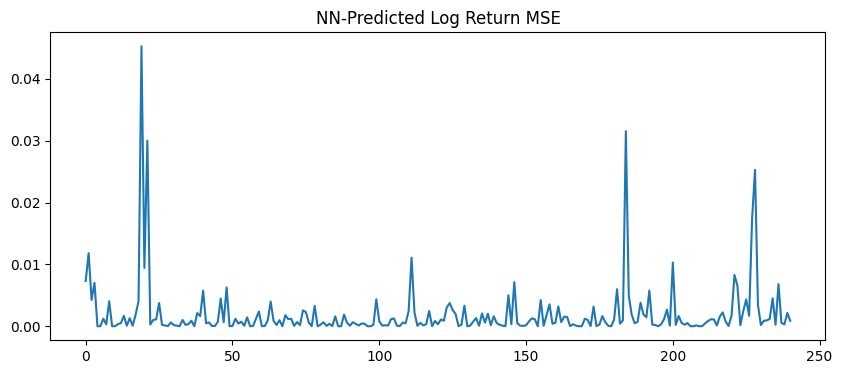

In [115]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title("NN-Predicted Log Return MSE")
ax.plot(pred_losses[win_sz:-win_sz-1]**2)
plt.show()

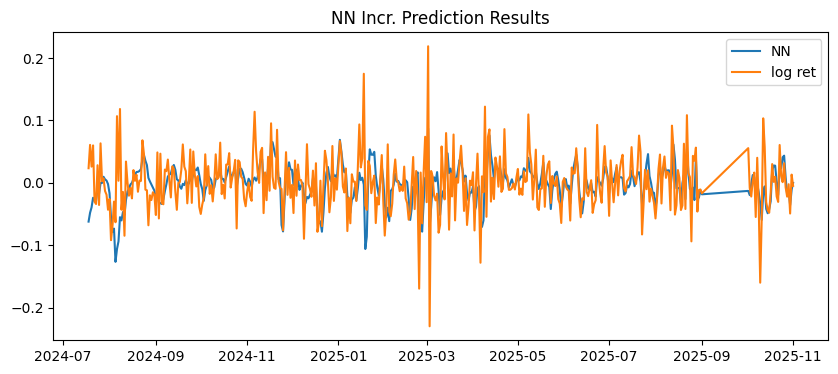

In [113]:
ser = pd.Series(predictions)
ser.index = df.index

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title("NN Incr. Prediction Results")
ax.plot(ser[win_sz:], label="NN")
ax.plot(df['log_ret'][win_sz:], label="log ret")
ax.legend()
plt.show()